In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


In [18]:
successes =0
failures = 0
trials = successes + failures
alpha_prior = 1  # Beta(1, 1) prior = uniform
beta_prior = 1

Successes: 0, Failures: 1
Bayesian Estimation (Beta Posterior):
  Posterior mean: 0.333
  5th percentile: 0.025
  95th percentile: 0.776


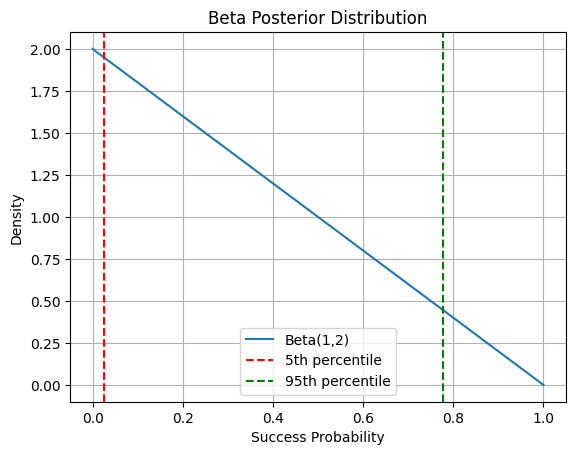

In [14]:

# -----------------------------------------------------------------------------------
# 1. Bayesian Estimation using Beta Distribution
# -----------------------------------------------------------------------------------

# Posterior: Beta(alpha + successes, beta + failures)
posterior_alpha = alpha_prior + successes
posterior_beta = beta_prior + failures

# Posterior mean and percentiles
posterior_mean = stats.beta.mean(posterior_alpha, posterior_beta)
ci_5 = stats.beta.ppf(0.05, posterior_alpha, posterior_beta)
ci_95 = stats.beta.ppf(0.95, posterior_alpha, posterior_beta)

print(f"Successes: {successes}, Failures: {failures}")
print("Bayesian Estimation (Beta Posterior):")
print(f"  Posterior mean: {posterior_mean:.3f}")
print(f"  5th percentile: {ci_5:.3f}")
print(f"  95th percentile: {ci_95:.3f}")

# Plot the beta posterior
x = np.linspace(0, 1, 500)
pdf = stats.beta.pdf(x, posterior_alpha, posterior_beta)

plt.figure()
plt.plot(x, pdf, label=f'Beta({posterior_alpha},{posterior_beta})')
plt.axvline(ci_5, color='red', linestyle='--', label='5th percentile')
plt.axvline(ci_95, color='green', linestyle='--', label='95th percentile')
plt.title("Beta Posterior Distribution")
plt.xlabel("Success Probability")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()




In [15]:

# -----------------------------------------------------------------------------------
# 2. Frequentist: Clopper-Pearson Confidence Interval (exact binomial CI)
# ----------------------------------------------------------------------------------
print(f"Successes: {successes}, Failures: {failures}")
alpha = 0.05
lower_cp, upper_cp = stats.binom.interval(1 - alpha, trials, successes / trials, loc=0)
lower_cp /= trials
upper_cp /= trials

print("\nClopper-Pearson Confidence Interval (95%):")
print(f"  Lower bound: {lower_cp:.3f}")
print(f"  Upper bound: {upper_cp:.3f}")


Successes: 0, Failures: 1

Clopper-Pearson Confidence Interval (95%):
  Lower bound: 0.000
  Upper bound: 0.000


In [16]:

# -----------------------------------------------------------------------------------
# 3. Hoeffding Bound (conservative, for bounded [0,1] variables)
# -----------------------------------------------------------------------------------
print(f"Successes: {successes}, Failures: {failures}")
# Hoeffding inequality: P(|mean - true| > ε) <= 2 * exp(-2 * n * ε^2)
# Solving for ε:
delta = 0.05  # Confidence level
empirical_mean = successes / trials
epsilon = np.sqrt(np.log(2 / delta) / (2 * trials))

hoeffding_lower = max(0, empirical_mean - epsilon)
hoeffding_upper = min(1, empirical_mean + epsilon)

print("\nHoeffding Bound (95% confidence):")
print(f"  Empirical mean: {empirical_mean:.3f}")
print(f"  Lower bound: {hoeffding_lower:.3f}")
print(f"  Upper bound: {hoeffding_upper:.3f}")


Successes: 0, Failures: 1

Hoeffding Bound (95% confidence):
  Empirical mean: 0.000
  Lower bound: 0.000
  Upper bound: 1.000


In [67]:
successes =1
failures = 5
trials = successes + failures
alpha_prior = 1  # Beta(1, 1) prior = uniform
beta_prior = 1

In [86]:
successes =0
failures = 1
trials = successes + failures
alpha_prior = 1  # Beta(1, 1) prior = uniform
beta_prior = 1
# -----------------------------------------------------------------------------------
# 4. Upper Confidence Bound (UCB) from bandits
# -----------------------------------------------------------------------------------
print(f"Successes: {successes}, Failures: {failures}")
# UCB: empirical_mean + sqrt(2 * log(n_total) / n_edge)
# Here we assume a total number of trials (e.g., over all edges or time steps)
n_total = 100  # Could be total planning steps or total samples
n_total = trials + 1
empirical_mean = successes / trials
ucb = empirical_mean + np.sqrt(2 * np.log(n_total) / trials)
ucb = min(1.0, ucb)

print(f"\nUpper Confidence Bound (UCB) with n_total={n_total}:")
print(f"  UCB estimate (n_total={n_total}): {ucb:.3f}")


Successes: 0, Failures: 1

Upper Confidence Bound (UCB) with n_total=2:
  UCB estimate (n_total=2): 1.000


In [142]:
import math
import heapq
import numpy as np
from collections import defaultdict

class GraphCUCBPlanner:
    def __init__(self, delta=None, force_total_rounds=None):
        self.adj = defaultdict(list)  # adjacency list: node -> list of (neighbor, edge_id)
        self.edge_stats = {}  # edge_id -> {'success': int, 'failure': int}
        self.edge_map = {}    # (u, v) -> edge_id
        self.total_rounds = 0
        self.delta=delta
        self.force_total_rounds = force_total_rounds

    def sink_nodes_set(self):
        """Return the set of nodes with no outgoing edges."""
        all_nodes = set()
        nodes_with_outgoing = set()



        for node, neighbors in self.adj.items():
            all_nodes.add(node)
            for neighbor, _ in neighbors:
                all_nodes.add(neighbor)
                nodes_with_outgoing.add(node)
        return all_nodes - nodes_with_outgoing
    
    def extend_path(self, path):
        """Return all possible extensions of the given path."""
        last_node = path[-1]
        neighbors = self.adj[last_node]
        return [path + [neighbor] for neighbor, _ in neighbors]
    
    def all_sink_paths(self, start_node):
        sink_nodes = self.sink_nodes_set()
        worklist = [[start_node]]
        all_sink_paths = []
        while worklist:
            path = worklist.pop(0)
            if path[-1] in sink_nodes:
                all_sink_paths.append(path)
            else:
                worklist.extend(self.extend_path(path))
        return all_sink_paths

    def add_edge(self, u, v, edge_id):
        """Add a directed edge from u to v with given edge_id."""
        self.adj[u].append((v, edge_id))
        self.edge_stats[edge_id] = {'success': 0, 'failure': 0}
        self.edge_map[(u, v)] = edge_id

    def record_result(self, edge_id, success):
        """Update the success/failure counts for an edge."""
        self.total_rounds += 1
        if success:
            self.edge_stats[edge_id]['success'] += 1
        else:
            self.edge_stats[edge_id]['failure'] += 1

    def set_results(self, results_dict):
        ''' results_dict is a dictionary of edge_id -> (success, failure)'''
        self.total_rounds = 0
        for edge_id, (success, failure) in results_dict.items():
            self.edge_stats[edge_id]['success'] = success
            self.edge_stats[edge_id]['failure'] = failure
            self.total_rounds += success + failure

    
    def compute_ucb(self, edge_id, quiet=True):
        """Return the UCB estimate for the success rate of an edge."""
        delta = self.delta
        s = self.edge_stats[edge_id]['success']
        f = self.edge_stats[edge_id]['failure']
        n = s + f
        if not quiet:
            print(f"Edge {edge_id} stats: success={s}, failure={f}, total={n}")
        
        if n == 0:
            if not quiet:
                print(f"Edge {edge_id} unexplored, returning optimistic 1.0")
            return 1.0  # Maximum optimism for unexplored edges
            
        empirical_mean = s / n
        if not quiet:
            print(f"Edge {edge_id} empirical mean: {empirical_mean:.3f}")
        
        if delta is None:
            bonus = np.sqrt(2 * np.log(self.total_rounds) / n)
            if not quiet:
                print(f"Edge {edge_id} default bonus: {bonus:.3f} (total_rounds={self.total_rounds})")
        else:
            if self.force_total_rounds is not None:
                bonus = math.sqrt(2 * math.log(max(1, self.force_total_rounds) / delta) / n)
            else:
                bonus = math.sqrt(2 * math.log(max(1, self.total_rounds) / delta) / n)
            if not quiet:
                print(f"Edge {edge_id} custom bonus: {bonus:.3f} (delta={delta})")
            
        result = min(1.0, empirical_mean + bonus)
        if not quiet:
            print(f"Edge {edge_id} final UCB: {result:.3f}")
        return result

    def plan_with_ucb(self, start, goal):
        """Use Dijkstra with -log(UCB) edge weights to find optimistic path."""
        heap = [(0.0, start, [])]  # (cost, current_node, path)
        visited = set()

        while heap:
            cost, node, path = heapq.heappop(heap)
            if node in visited:
                continue
            visited.add(node)

            if node == goal:
                return path, math.exp(-cost)  # convert back to estimated path success

            for neighbor, edge_id in self.adj[node]:
                ucb = self.compute_ucb(edge_id)
                edge_cost = -math.log(ucb + 1e-9)  # avoid log(0)
                heapq.heappush(heap, (cost + edge_cost, neighbor, path + [edge_id]))

        return None, 0.0  # no path found
    
    def compute_path_estimated_path_success(self, path):
        cost, path_idx = 0.0, 0
        while path_idx < len(path) - 1 :
            path_idx += 1
            next_edge = (path[path_idx-1], path[path_idx])
            if next_edge not in self.edge_map:
                raise ValueError(f"Edge {next_edge} not found in edge_map")
            edge_id = self.edge_map[next_edge]
            ucb = self.compute_ucb(edge_id)
            edge_cost = -math.log(ucb + 1e-9)
            cost += edge_cost
            # Now cost is the cost to get to path[path_idx]
        return math.exp(-cost)
    
    def compute_estimated_success_all_sink_paths(self, start):
        all_sink_paths = list(self.all_sink_paths(start))
        return [(path, self.compute_path_estimated_path_success(path)) for path in all_sink_paths]

    def most_optimistic_sink_paths(self, start, slack = 0.01):
        path_success_pairs = self.compute_estimated_success_all_sink_paths(start)
        max_success = path_success_pairs[0][1]
        for path, success in path_success_pairs:
            if success >= max_success:
                max_success = success
        good_paths = []
        for path, success in path_success_pairs:
            if success >= max_success - slack:
                good_paths.append((path, success))
        return good_paths
    
    def print_edge_stats(self):
        print(f"Total rounds: {self.total_rounds}")
        for edge_id, stats in self.edge_stats.items():
            s, f = stats['success'], stats['failure']
            ucb = self.compute_ucb(edge_id)
            print(f"Edge {edge_id}: {s} success, {f} fail, UCB={ucb:.3f}")

    

# -----------------------
# Example Usage
# -----------------------

# Define graph
planner = GraphCUCBPlanner()
planner.add_edge("START", "A", "e1")
planner.add_edge("START", "B", "e2")
planner.add_edge("A", "GOAL", "e3")
planner.add_edge("B", "GOAL", "e4")

# Simulate some trials (you could replace this with real results)
# planner.record_result("e1", success=True)
# planner.record_result("e1", success=False)
# planner.record_result("e3", success=True)
# planner.record_result("e4", success=True)
# planner.record_result("e4", success=True)

results_dict = {
    "e1": (3, 1),
    "e2": (0, 1),
    "e3": (3, 0),
    "e4": (0, 0)
}
results_dict = {
    "e1": (0, 2),
    "e2": (0, 0),
    "e3": (0, 0),
    "e4": (0, 0)
}
planner.delta = 0.8
planner.force_total_rounds = None
planner.set_results(results_dict)


# Plan
planner.print_edge_stats()
path, estimated_success = planner.plan_with_ucb("START", "GOAL")

print("\nPlanned path:", path)
print(f"Estimated path success: {estimated_success:.3f}")
start_node = "START"
for path, estimated_success in planner.compute_estimated_success_all_sink_paths(start_node):
    print(f"Path: {path}, Estimated success: {estimated_success:.3f}")
print("Most optimistic sink paths:")
for path, estimated_success in planner.most_optimistic_sink_paths(start_node, slack=0.0001):
    print(f"Path: {path}, Estimated success: {estimated_success:.3f}")


Total rounds: 2
Edge e1: 0 success, 2 fail, UCB=0.957
Edge e2: 0 success, 0 fail, UCB=1.000
Edge e3: 0 success, 0 fail, UCB=1.000
Edge e4: 0 success, 0 fail, UCB=1.000

Planned path: ['e2', 'e4']
Estimated path success: 1.000
Path: ['START', 'A', 'GOAL'], Estimated success: 0.957
Path: ['START', 'B', 'GOAL'], Estimated success: 1.000
Most optimistic sink paths:
Path: ['START', 'B', 'GOAL'], Estimated success: 1.000


In [ ]:
symbolic_al

In [33]:
print(planner.sink_nodes_set())
print(planner.all_sink_paths("START"))

{'START'}
[['START']]
